# Homework 5

Implement a Kalman Filter to estimate the position and orientation of a vehicle from a GPS and an IMU. 
GPS provides global position information but can have accuracy issues due to signal obstructions and multipath errors.
IMU provides high-frequency acceleration and angular velocity measurements but suffers from drift over time. 
The idea is to fuse the data from these sensors and improve the accuracy and reliability of pose estimation for navigation applications.

The Data was collected from the NUANCE autonomous car and stored in a rosbag: https://drive.google.com/file/d/13NTbaSxY7uYbRrld7iVXB27czxcrRTL9/view?usp=drive_link 

We will use "/gps/fix" and "/imu/imu_uncompensated"

In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geo_transforms

# b = bagreader('/home/meuli/src/eece7150/HW5/2023-10-19-14-14-38-filtered.bag')

# # get the list of topics
# print(b.topic_table)

# data_gps = b.message_by_topic('/gps/fix')
# data_imu = b.message_by_topic('/imu/imu_uncompensated')

data_gps = "2023-10-19-14-14-38-filtered/gps-fix.csv"
data_imu = "2023-10-19-14-14-38-filtered/imu-imu_uncompensated.csv"


In [2]:
# Store  GPS date
gps_lat = pd.read_csv(data_gps, index_col=7)
gps_lon = pd.read_csv(data_gps, index_col=8)

# Store IMU date
imu_time = pd.read_csv(data_imu, index_col=0)
ang_vel_x = pd.read_csv(data_imu, index_col=18)
ang_vel_y = pd.read_csv(data_imu, index_col=19)
ang_vel_z = pd.read_csv(data_imu, index_col=20)
lin_accel_x = pd.read_csv(data_imu, index_col=30)
lin_accel_y = pd.read_csv(data_imu, index_col=31)
lin_accel_z = pd.read_csv(data_imu, index_col=32)

In [91]:
gps_time = pd.read_csv(data_gps, index_col=0)

# Kalman Filter Implementation
Code up the Kalman Filter to compute pose estimates using Python.
Define and write up the equations for your process and measurement models, their covariances, and parameters in the Jupyter Notebook.
Define and report the initial conditions, as well. Develop functions for prediction and correction steps and estimate the state iteratively.

Implement a kalman filter to estimate 2D (x, y, theta) pose of the vehicle by fusing GPS and IMU measurements. Use constant-velocity model for IMU or include acceleration component.

Ignore computer accelerometer and gyroscope biases. Estimate them initially by averaging the readings at rest and subtracting them from your readings to unbias the measurements. Assume constant biases.

The process model, measurement model, and covariance update equations must be programmed independently. 

In [3]:
gps_data = np.array([gps_lon.index[:], gps_lat.index[:]])

origin = gps_data[:,2737]  # set the initial position to the origin
print(origin)

gt_trajectory_xyz = geo_transforms.lla_to_enu(gps_data, origin)

gps_x, gps_y, _ = gt_trajectory_xyz

[-71.0841655  42.342004 ]


In [9]:
from scipy import integrate

In [66]:
# Perform IMU Dead Reckoning
imu_lin_accel_data = np.array([lin_accel_x.index[:], lin_accel_y.index[:], lin_accel_z.index[:]])
lin_x, lin_y, lin_z = imu_lin_accel_data

theta = 0  # Initial orientation

time0 = imu_time.index[0]

lin_x1 = lin_x - np.mean(lin_x)

imu_v = integrate.cumtrapz(lin_x1, imu_time.index[:])
imu_p = integrate.cumtrapz(imu_v, imu_time.index[1:])


ang_vel = ang_vel_z.index[:] - np.mean(ang_vel_z.index[:])

yaw_angle = integrate.cumtrapz(ang_vel, imu_time.index[:])

px = []
py = []

for i in range(1, len(lin_accel_x)-1):
    dt = imu_time.index[i] - time0
    time0 = imu_time.index[i]

    px.append(-imu_v[i] * np.cos(yaw_angle[i]))
    py.append(imu_v[i] * np.sin(yaw_angle[i]))

imu_pE = integrate.cumtrapz(px, imu_time.index[2:])
imu_pN = integrate.cumtrapz(py, imu_time.index[2:])

    

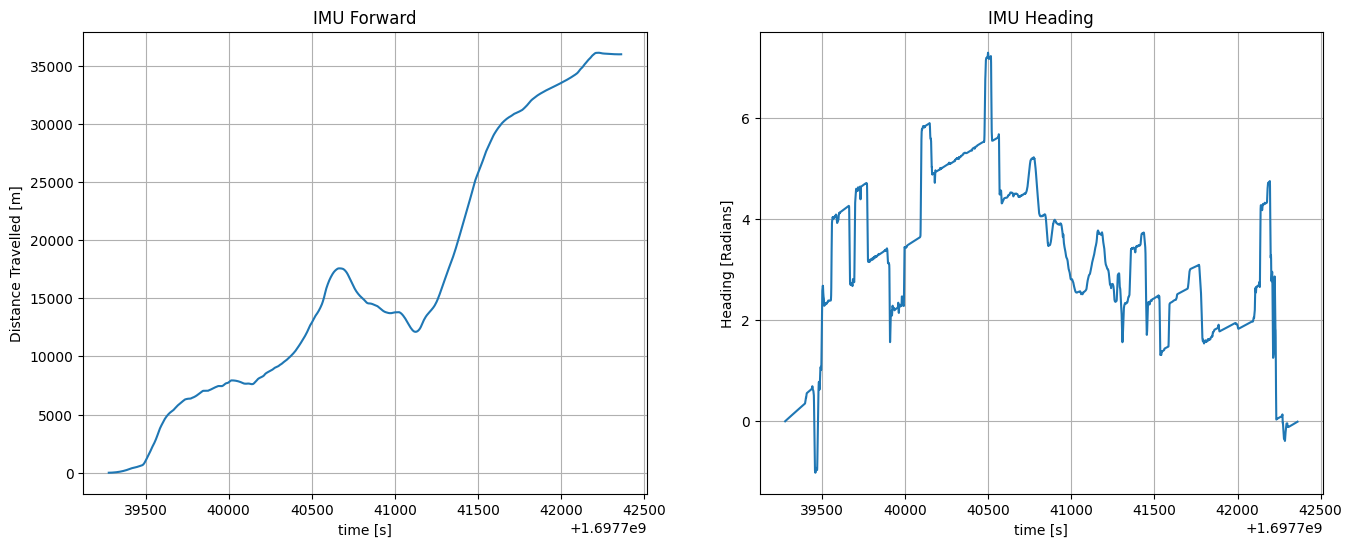

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(imu_time.index[2::], imu_p)
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('Distance Travelled [m]')
ax[0].set_title('IMU Forward')
ax[0].grid()
ax[1].plot(imu_time.index[1:], yaw_angle)
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('Heading [Radians]')
ax[1].set_title('IMU Heading')
ax[1].grid()

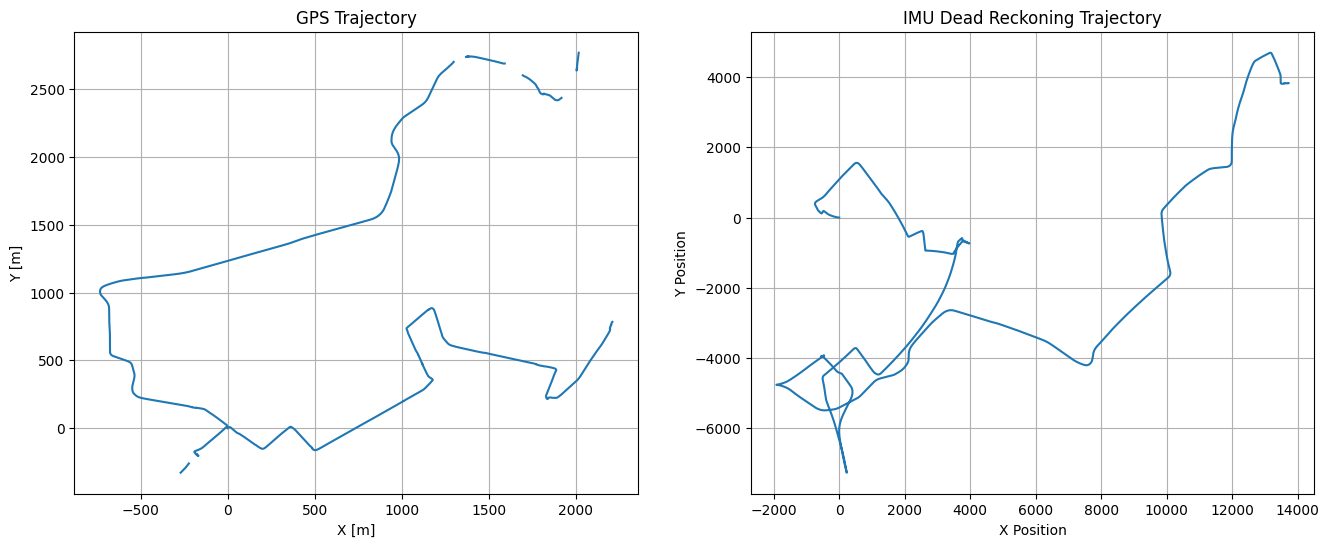

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(gps_x, gps_y)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS Trajectory')
ax[0].grid()

# Plot the dead reckoning trajectory
ax[1].plot(imu_pE, imu_pN)
ax[1].set_xlabel('X Position')
ax[1].set_ylabel('Y Position')
ax[1].set_title('IMU Dead Reckoning Trajectory')
ax[1].grid()

## Apply Kalman filter!

Let's apply Kalman filter to the GPS/IMU sequence to estimate vehicle 2d pose [x, y, theta].

Be aware that the ground-truth data is used only for the evaluation. i.e., only noised GPS/IMU sequence is given to the filter.

### Prepare initial estimate and its error covariance

Suppose initial 2d position [x, y] estimation are initialized with the first GPS observation.

Since our vehicle has no sensor to measure yaw angle, yaw estimation is initialized randomly and its variance is initialized with some large value (e.g. pi).

In [78]:
# Noise Def
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meter
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

In [79]:
# initial state x_0

initial_yaw_std = np.pi
initial_yaw = yaw_angle[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    gps_x[0],
    gps_y[0],
    initial_yaw
])

In [80]:
# covariance for initial state estimation error (Sigma_0)


P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [81]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [82]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

In [90]:
print(len(gps_y))
print(len(imu_v))

30758
616321


### Kalman filter main routine

In [95]:
def interpolate_gps_data(imu_timestamps, gps_timestamps, gps_data_x, gps_data_y):
    # Interpolate GPS data to match IMU data timestamps
    interpolated_gps_data = []
    for imu_timestamp in imu_timestamps:
        # Find the closest GPS timestamp before the IMU timestamp
        closest_gps_timestamp_index = np.argmin(gps_timestamps <= imu_timestamp)

        # Find the next GPS timestamp after the IMU timestamp
        next_gps_timestamp_index = np.argmin(gps_timestamps > imu_timestamp)

        # Calculate the time difference between the IMU timestamp and the two closest GPS timestamps
        time_difference_before = imu_timestamp - gps_timestamps[closest_gps_timestamp_index]
        time_difference_after = gps_timestamps[next_gps_timestamp_index] - imu_timestamp

        # Calculate the weights for interpolation
        weight_before = time_difference_after / (time_difference_before + time_difference_after)
        weight_after = time_difference_before / (time_difference_before + time_difference_after)

        # Interpolate the GPS data
        interpolated_gps_x = weight_before * gps_data_x[closest_gps_timestamp_index] + weight_after * gps_data_x[next_gps_timestamp_index]
        interpolated_gps_y = weight_before * gps_data_y[closest_gps_timestamp_index] + weight_after * gps_data_y[next_gps_timestamp_index]

        # Append the interpolated GPS datum to the list
        interpolated_gps_data.append((interpolated_gps_x, interpolated_gps_y))

    return interpolated_gps_data

In [97]:
my_gps_data = interpolate_gps_data(imu_time.index[:], gps_time.index[:], gps_x, gps_y)

/tmp/ipykernel_253989/50040239.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  weight_before = time_difference_after / (time_difference_before + time_difference_after)
/tmp/ipykernel_253989/50040239.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  weight_after = time_difference_before / (time_difference_before + time_difference_after)


In [100]:
print(len(my_gps_data))
print(len(imu_v))

616322
616321


In [87]:
from extended_kalman_filter import ExtendedKalmanFilter as EKF
from utils import normalize_angles

N = len(imu_time.index[:])  # number of data point

In [88]:
# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
for t_idx in range(1, N):
    t = imu_time.index[t_idx]
    dt = t - t_last
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        imu_v[t_idx],
        ang_vel[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    kf.propagate(u, dt, R)
    
    # get measurement `z = [x, y] + noise`
    z = np.array([
        gps_x[t_idx],
        gps_y[t_idx]
    ])
    
    # update!
    kf.update(z, Q)
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    
    t_last = t
    

mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

IndexError: index 30758 is out of bounds for axis 0 with size 30758

## Visualize estimated results

### trajectory

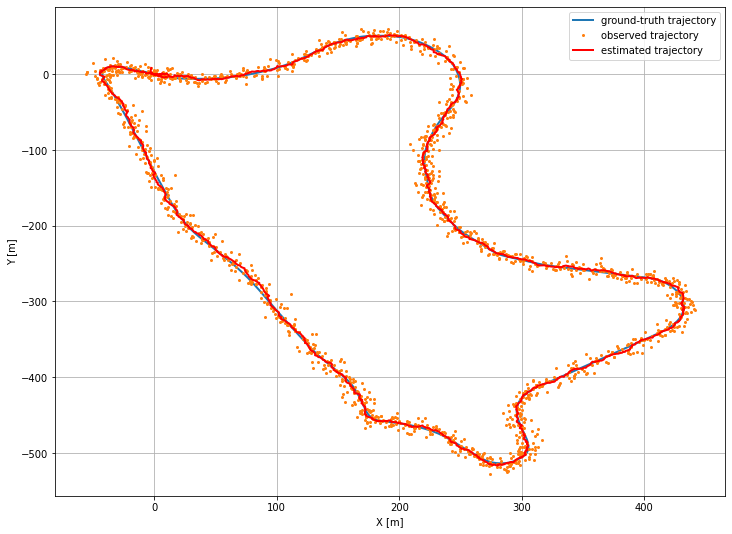

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = obs_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

# Discussion and Analysis
Plot the raw GPS reading, Deadreckoned IMU estimates and the Kalman filtered state estimates of both the translational and rotational components. 

Reflect on the results and discuss the advantages and limitations of the Kalman filter fusion in improving position estimation.